In [215]:
from __future__ import print_function

%matplotlib inline
import seaborn as sns
import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [216]:
df=pd.read_csv('train.csv')

In [217]:
sagemaker_session = sagemaker.Session()

In [218]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = "deepar-salesdata-demo-notebook"  # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [219]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [129]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [130]:
df = df[['Order Date', 'Sales']]

In [131]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  9800 non-null   datetime64[ns]
 1   Sales       9800 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 153.2 KB


In [133]:
df=df.resample('D', label='right', closed = 'right', on='Order Date').sum()
new_df=df.index.to_frame(index=False)
df= df.merge(new_df,on='Order Date',how='left')
df.head()

,Order Date,Sales
0,2015-01-02,468.900
1,2015-01-03,2203.151
2,2015-01-04,119.888
3,2015-01-05,0.000
4,2015-01-06,5188.520


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  1459 non-null   datetime64[ns]
 1   Sales       1459 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 34.2 KB


<AxesSubplot:xlabel='Order Date', ylabel='Sales'>

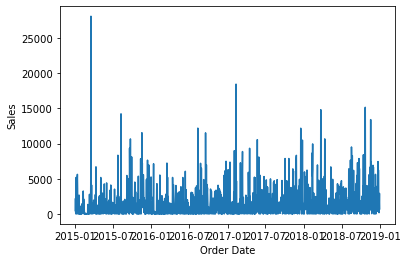

In [135]:
sns.lineplot(x=df['Order Date'], y=df['Sales'])

In [10]:
print("Start date is: ", df['Order Date'].min())
print("End date is: ", df['Order Date'].max())

Start date is:  2015-01-02 00:00:00
End date is:  2018-12-30 00:00:00


In [11]:
df['Order Date'][1021]

Timestamp('2017-10-19 00:00:00')

In [12]:
df['Order Date'][1022]

Timestamp('2017-10-20 00:00:00')

In [13]:
train, test = df.loc[df['Order Date'] <= '2017-10-19 00:00:00'], df.loc[df['Order Date'] > '2017-10-19 00:00:00']

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 0 to 1021
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  1022 non-null   datetime64[ns]
 1   Sales       1022 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 24.0 KB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437 entries, 1022 to 1458
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  437 non-null    datetime64[ns]
 1   Sales       437 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.2 KB


In [16]:
train=train.set_index('Order Date')

In [17]:
train.head()

,Sales
Order Date,
2015-01-02,468.900
2015-01-03,2203.151
2015-01-04,119.888
2015-01-05,0.000
2015-01-06,5188.520


In [18]:
test=test.set_index('Order Date')

In [19]:
test.head()

,Sales
Order Date,
2017-10-20,946.174
2017-10-21,7877.272
2017-10-22,188.280
2017-10-23,467.422
2017-10-24,1365.498


In [20]:
train=train.values
test=test.values

In [21]:
train

array([[ 468.9  ],
       [2203.151],
       [ 119.888],
       ...,
       [2953.346],
       [ 307.92 ],
       [   0.   ]])

In [27]:
train = train.flatten()
test = test.flatten()

In [220]:
df=pd.read_csv('train.csv')

In [221]:
del df['Row ID'],df['Order ID'],df['Ship Date'],df['Ship Mode'],df['Customer ID'],df['Customer Name'],df['Segment'],df['Country']

In [222]:
del df['City'],df['State'],df['Postal Code'],df['Region'],df['Product ID'],df['Category'],df['Sub-Category'],df['Product Name']

In [223]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df = df.sort_values(by=['Order Date'])
df


,Order Date,Sales
540,2015-01-02,468.900
5713,2015-01-03,5.940
157,2015-01-03,457.568
6548,2015-01-03,17.472
7949,2015-01-03,63.552
...,...,...
908,2018-12-30,52.776
645,2018-12-30,209.300
907,2018-12-30,90.930
906,2018-12-30,323.136


In [224]:
df = df.set_index('Order Date')
df.head()

,Sales
Order Date,
2015-01-02,468.900
2015-01-03,5.940
2015-01-03,457.568
2015-01-03,17.472
2015-01-03,63.552


In [225]:
df = df.resample('D').sum()
df.head()

,Sales
Order Date,
2015-01-02,468.900
2015-01-03,2203.151
2015-01-04,119.888
2015-01-05,0.000
2015-01-06,5188.520


In [142]:
"""size = int(len(df)*0.8)"""

'size = int(len(df)*0.8)'

In [143]:
"""train_df =  df.iloc[:size]
test_df  =  df.iloc[size:]"""

'train_df =  df.iloc[:size]\ntest_df  =  df.iloc[size:]'

In [144]:
"""train_df.head()"""

'train_df.head()'

In [145]:
"""train_df.tail()"""

'train_df.tail()'

In [226]:
start_dataset =pd.Timestamp("2015-01-02",freq='D')
end_training = pd.Timestamp("2018-03-13",freq='D')

/tmp/ipykernel_31527/4106656742.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_dataset =pd.Timestamp("2015-01-02",freq='D')
/tmp/ipykernel_31527/4106656742.py:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  end_training = pd.Timestamp("2018-03-13",freq='D')


In [227]:
start_dataset

Timestamp('2015-01-02 00:00:00', freq='D')

In [228]:
traget_list=df[start_dataset:end_training -pd.Timedelta(1)].values.round(2).tolist()

In [229]:
traget_array = np. array(traget_list)

In [230]:
traget_array_flatten=traget_array.flatten()

In [231]:
training_target=traget_array_flatten.tolist()

In [152]:
training_data = [{
    'start':str(start_dataset),
    'target':training_target
}]

In [153]:
"""#practice cell
training_data = [{
    'start':str(start_dataset),
    'target':df[start_dataset:end_training -pd.Timedelta(1)].values.round(2).flatten()
}]"""

"#practice cell\ntraining_data = [{\n    'start':str(start_dataset),\n    'target':df[start_dataset:end_training -pd.Timedelta(1)].values.round(2).flatten()\n}]"

In [154]:
training_data

[{'start': '2015-01-02 00:00:00',
  'target': [468.9,
   2203.15,
   119.89,
   0.0,
   5188.52,
   601.02,
   228.33,
   469.44,
   4.71,
   4637.82,
   5624.39,
   3553.8,
   61.96,
   149.95,
   299.96,
   0.0,
   64.86,
   378.59,
   2673.87,
   0.0,
   0.0,
   40.08,
   0.0,
   0.0,
   1097.25,
   426.67,
   3.93,
   0.0,
   240.5,
   290.67,
   0.0,
   211.65,
   47.76,
   1458.56,
   506.12,
   738.6,
   79.56,
   886.28,
   3254.15,
   598.14,
   2126.37,
   1771.81,
   0.0,
   576.73,
   21.36,
   9.04,
   54.21,
   37.78,
   0.0,
   95.59,
   8.85,
   19.44,
   11.36,
   55.67,
   0.0,
   0.0,
   19.46,
   0.0,
   16.45,
   97.11,
   1345.89,
   0.0,
   72.63,
   531.16,
   0.0,
   477.99,
   22.08,
   862.68,
   2784.16,
   505.88,
   0.0,
   2108.55,
   370.78,
   471.92,
   3960.36,
   28106.72,
   590.76,
   0.0,
   4109.82,
   464.09,
   945.06,
   65.38,
   459.15,
   145.13,
   0.0,
   1493.22,
   890.84,
   1170.32,
   1959.55,
   288.06,
   134.38,
   370.45,
   475.

In [155]:
traget_list=df[start_dataset:end_training + pd.Timedelta(prediction_length)].values.round(2).tolist()

In [156]:
traget_array = np. array(traget_list)

In [157]:
traget_array_flatten=traget_array.flatten()

In [158]:
testing_target=traget_array_flatten.tolist()

In [159]:
prediction_length = 365

In [160]:
test_data = [{
    'start':str(start_dataset),
    'target':testing_target
}]

In [161]:
"""#practice cell
test_data = [{
    'start':str(start_dataset),
    'target':df[start_dataset:end_training + pd.Timedelta(prediction_length)].values.round(2).flatten()
    
}]
"""

"#practice cell\ntest_data = [{\n    'start':str(start_dataset),\n    'target':df[start_dataset:end_training + pd.Timedelta(prediction_length)].values.round(2).flatten()\n    \n}]\n"

In [162]:
'''b= test_data.ravel'''

'b= test_data.ravel'

In [163]:
test_data

[{'start': '2015-01-02 00:00:00',
  'target': [468.9,
   2203.15,
   119.89,
   0.0,
   5188.52,
   601.02,
   228.33,
   469.44,
   4.71,
   4637.82,
   5624.39,
   3553.8,
   61.96,
   149.95,
   299.96,
   0.0,
   64.86,
   378.59,
   2673.87,
   0.0,
   0.0,
   40.08,
   0.0,
   0.0,
   1097.25,
   426.67,
   3.93,
   0.0,
   240.5,
   290.67,
   0.0,
   211.65,
   47.76,
   1458.56,
   506.12,
   738.6,
   79.56,
   886.28,
   3254.15,
   598.14,
   2126.37,
   1771.81,
   0.0,
   576.73,
   21.36,
   9.04,
   54.21,
   37.78,
   0.0,
   95.59,
   8.85,
   19.44,
   11.36,
   55.67,
   0.0,
   0.0,
   19.46,
   0.0,
   16.45,
   97.11,
   1345.89,
   0.0,
   72.63,
   531.16,
   0.0,
   477.99,
   22.08,
   862.68,
   2784.16,
   505.88,
   0.0,
   2108.55,
   370.78,
   471.92,
   3960.36,
   28106.72,
   590.76,
   0.0,
   4109.82,
   464.09,
   945.06,
   65.38,
   459.15,
   145.13,
   0.0,
   1493.22,
   890.84,
   1170.32,
   1959.55,
   288.06,
   134.38,
   370.45,
   475.

In [164]:
test_data

[{'start': '2015-01-02 00:00:00',
  'target': [468.9,
   2203.15,
   119.89,
   0.0,
   5188.52,
   601.02,
   228.33,
   469.44,
   4.71,
   4637.82,
   5624.39,
   3553.8,
   61.96,
   149.95,
   299.96,
   0.0,
   64.86,
   378.59,
   2673.87,
   0.0,
   0.0,
   40.08,
   0.0,
   0.0,
   1097.25,
   426.67,
   3.93,
   0.0,
   240.5,
   290.67,
   0.0,
   211.65,
   47.76,
   1458.56,
   506.12,
   738.6,
   79.56,
   886.28,
   3254.15,
   598.14,
   2126.37,
   1771.81,
   0.0,
   576.73,
   21.36,
   9.04,
   54.21,
   37.78,
   0.0,
   95.59,
   8.85,
   19.44,
   11.36,
   55.67,
   0.0,
   0.0,
   19.46,
   0.0,
   16.45,
   97.11,
   1345.89,
   0.0,
   72.63,
   531.16,
   0.0,
   477.99,
   22.08,
   862.68,
   2784.16,
   505.88,
   0.0,
   2108.55,
   370.78,
   471.92,
   3960.36,
   28106.72,
   590.76,
   0.0,
   4109.82,
   464.09,
   945.06,
   65.38,
   459.15,
   145.13,
   0.0,
   1493.22,
   890.84,
   1170.32,
   1959.55,
   288.06,
   134.38,
   370.45,
   475.

In [165]:
%%time

import os
import boto3
import sagemaker

from sagemaker import get_execution_role

region = boto3.Session().region_name

role = get_execution_role()

CPU times: user 31.2 ms, sys: 53 µs, total: 31.3 ms
Wall time: 75.4 ms


In [166]:
bucket = sagemaker.Session().default_bucket()

In [167]:
bucket_path = "https://s3-{}.amazonaws.com/{}".format(region, bucket)

In [168]:
import json

In [169]:
def write_dicts_to_file(path,df):
    with open(path,'wb') as fp :
        for d in df:
            fp.write(json.dumps(d).encode('utf-8'))
            fp.write('\n'.encode('utf-8'))

In [170]:
%%time
write_dicts_to_file('train_daily.json',training_data)
write_dicts_to_file('test_daily.json',test_data)

CPU times: user 2.19 ms, sys: 0 ns, total: 2.19 ms
Wall time: 1.73 ms


In [171]:
s3 = boto3.resource("s3")


def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                "File s3://{}/{} already exists.\nSet override to upload anyway.\n".format(
                    s3_bucket, s3_path
                )
            )
            return
        else:
            print("Overwriting existing file")
    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        buk.put_object(Key=path, Body=data)

In [172]:
%%time
copy_to_s3("train_daily.json", s3_data_path + "/train/train_daily.json")
copy_to_s3("test_daily.json", s3_data_path + "/test/test_daily.json")

Uploading file to s3://sagemaker-us-east-1-101718508260/deepar-salesdata-demo-notebook/data/train/train_daily.json
Uploading file to s3://sagemaker-us-east-1-101718508260/deepar-salesdata-demo-notebook/data/test/test_daily.json
CPU times: user 33.4 ms, sys: 3.14 ms, total: 36.5 ms
Wall time: 241 ms


In [173]:
s3_sample = s3.Object(s3_bucket, s3_prefix + "/data/train/train_daily.json").get()["Body"].read()
StringVariable = s3_sample.decode("UTF-8", "ignore")
lines = StringVariable.split("\n")
print(lines[0][:100] + "...")

{"start": "2015-01-02 00:00:00", "target": [468.9, 2203.15, 119.89, 0.0, 5188.52, 601.02, 228.33, 46...


In [174]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)

In [175]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.c4.2xlarge",
    base_job_name="deepar-sales-demo",
    output_path=s3_output_path,
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [176]:
hyperparameters = {
    "time_freq": 'D',
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": 100,
    "prediction_length": 100,
}

In [177]:
estimator.set_hyperparameters(**hyperparameters)

In [178]:
%%time
data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

estimator.fit(inputs=data_channels, wait=True)

2022-09-14 16:17:09 Starting - Starting the training job...
2022-09-14 16:17:36 Starting - Preparing the instances for trainingProfilerReport-1663172229: InProgress
......
2022-09-14 16:18:36 Downloading - Downloading input data...
2022-09-14 16:18:56 Training - Downloading the training image........Arguments: train
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[09/14/2022 16:20:18 INFO 139830709036864] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_obje

In [179]:
from sagemaker.serializers import IdentitySerializer

In [184]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=["0.1", "0.5", "0.9"],
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(
            ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None
        )

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles,
        }

        http_request_data = {"instances": [instance], "configuration": configuration}

        return json.dumps(http_request_data).encode("utf-8")

def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_length = len(next(iter(predictions["quantiles"].values())))
        prediction_index = pd.date_range(
            start=prediction_time, freq=freq, periods=prediction_length
        )
        if return_samples:
            dict_of_samples = {"sample_" + str(i): s for i, s in enumerate(predictions["samples"])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions["quantiles"], **dict_of_samples}, index=prediction_index
        )

def set_frequency(self, freq):
        self.freq = freq


def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]
def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj

In [185]:
predictor = estimator.deploy(
    initial_instance_count=1, instance_type="ml.m5.large", predictor_cls=DeepARPredictor
)

-------!

In [214]:
predictor.predict(ts=series, quantiles=[0.10, 0.5, 0.90]).head()

TypeError: 'builtin_function_or_method' object is not subscriptable

In [198]:
timeseries = df.squeeze(axis=1)

In [199]:
timeseries = 

Order Date
2015-01-02     468.9000
2015-01-03    2203.1510
2015-01-04     119.8880
2015-01-05       0.0000
2015-01-06    5188.5200
                ...    
2018-12-26     814.5940
2018-12-27     177.6360
2018-12-28    1657.3508
2018-12-29    2915.5340
2018-12-30     713.7900
Freq: D, Name: Sales, Length: 1459, dtype: float64

In [204]:
traget_array_flatten

array([ 468.9 , 2203.15,  119.89, ..., 4536.94, 1403.84, 4791.35])

In [212]:
series=pd.Series(traget_array_flatten).to_list()
series

[468.9,
 2203.15,
 119.89,
 0.0,
 5188.52,
 601.02,
 228.33,
 469.44,
 4.71,
 4637.82,
 5624.39,
 3553.8,
 61.96,
 149.95,
 299.96,
 0.0,
 64.86,
 378.59,
 2673.87,
 0.0,
 0.0,
 40.08,
 0.0,
 0.0,
 1097.25,
 426.67,
 3.93,
 0.0,
 240.5,
 290.67,
 0.0,
 211.65,
 47.76,
 1458.56,
 506.12,
 738.6,
 79.56,
 886.28,
 3254.15,
 598.14,
 2126.37,
 1771.81,
 0.0,
 576.73,
 21.36,
 9.04,
 54.21,
 37.78,
 0.0,
 95.59,
 8.85,
 19.44,
 11.36,
 55.67,
 0.0,
 0.0,
 19.46,
 0.0,
 16.45,
 97.11,
 1345.89,
 0.0,
 72.63,
 531.16,
 0.0,
 477.99,
 22.08,
 862.68,
 2784.16,
 505.88,
 0.0,
 2108.55,
 370.78,
 471.92,
 3960.36,
 28106.72,
 590.76,
 0.0,
 4109.82,
 464.09,
 945.06,
 65.38,
 459.15,
 145.13,
 0.0,
 1493.22,
 890.84,
 1170.32,
 1959.55,
 288.06,
 134.38,
 370.45,
 475.84,
 187.43,
 456.27,
 247.41,
 2743.15,
 0.0,
 728.75,
 6693.75,
 129.98,
 638.58,
 0.0,
 294.72,
 39.07,
 0.0,
 1020.53,
 205.47,
 1250.45,
 845.36,
 257.75,
 643.98,
 0.0,
 2379.99,
 282.57,
 0.0,
 2578.48,
 768.84,
 1048.74,
 

In [213]:
type(series)

list